<a href="https://colab.research.google.com/github/kardwalker/Malaria-model-/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense ,BatchNormalization
from tensorflow.keras.losses import BinaryCr    siossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy , Precision , Recall , AUC , F1Score , FalsePositives , FalseNegatives , TrueNegatives , TruePositives
from tensorflow.keras import regularizers
import seaborn as sns
import sklearn
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

In [ ]:
dataset , ds_info = tfds.load("malaria"  , with_info = True , as_supervised=True , shuffle_files=True , split=["train"])

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [ ]:
dataset[0]

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

to do run this code, an example for spliting

In [ ]:
"""train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2
dataset = tf.data.Dataset.range(10)
print(list(dataset.as_numpy_iterator()))
dataset_size = len(dataset)
train_dataset = dataset.take(int(train_ratio*dataset_size))
val_dataset = dataset.skip(int(train_ratio*dataset_size)).take(int(val_ratio*dataset_size))
test_dataset = dataset.skip(int(train_ratio*dataset_size)+int(val_ratio*dataset_size))
print(list(train_dataset.as_numpy_iterator()))
print(list(val_dataset.as_numpy_iterator()))
print(list(test_dataset.as_numpy_iterator()))"""

'train_ratio = 0.7\nval_ratio = 0.1\ntest_ratio = 0.2\ndataset = tf.data.Dataset.range(10)\nprint(list(dataset.as_numpy_iterator()))\ndataset_size = len(dataset)\ntrain_dataset = dataset.take(int(train_ratio*dataset_size))\nval_dataset = dataset.skip(int(train_ratio*dataset_size)).take(int(val_ratio*dataset_size))\ntest_dataset = dataset.skip(int(train_ratio*dataset_size)+int(val_ratio*dataset_size))\nprint(list(train_dataset.as_numpy_iterator()))\nprint(list(val_dataset.as_numpy_iterator()))\nprint(list(test_dataset.as_numpy_iterator()))'

In [ ]:
def split(dataset , train_ratio,val_ratio,test_ratio):
  dataset_size = len(dataset)
  train_dataset = dataset.take(int(train_ratio*dataset_size))
  val_dataset = dataset.skip(int(train_ratio*dataset_size)).take(int(val_ratio*dataset_size))
  test_dataset = dataset.skip(int(train_ratio*dataset_size)+int(val_ratio*dataset_size))
  #print(list(train_dataset.as_numpy_iterator()))
  #print(list(val_dataset.as_numpy_iterator()))
  #print(list(test_dataset.as_numpy_iterator()))
  return train_dataset,val_dataset,test_dataset


In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_dataset, val_dataset, test_dataset = split(dataset[0],train_ratio,val_ratio,test_ratio)

Data visualization

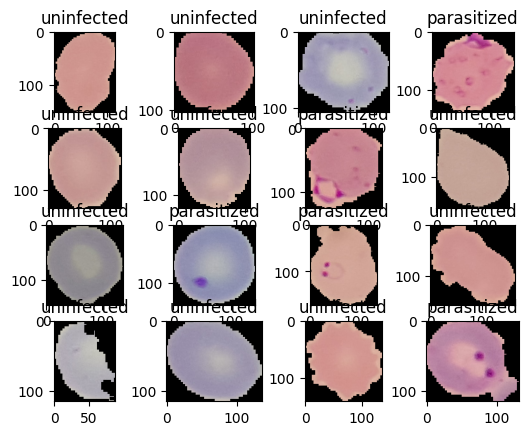

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(ds_info.features["label"].int2str(label))


Data preprocessing


In [ ]:
def resizie_rescale(image, label):
  image = tf.image.resize(image, (224, 224))/255.0
  return image, label

In [ ]:
train_dataset = train_dataset.map(resizie_rescale)
val_dataset = val_dataset.map(resizie_rescale)
test_dataset = test_dataset.map(resizie_rescale)
print(test_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration=True , ).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration=True , ).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# reducing the kernel size help us extract more features
print(val_dataset)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape =(224 ,224 ,3)),
    Conv2D(filters=6,kernel_size=3,strides =1, padding = "valid" , activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=2,strides=2,padding="valid"),
    Conv2D(filters=16,kernel_size=3,strides =1, padding = "valid" , activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=2,strides=2,padding="valid"),
    Conv2D(filters=32,kernel_size=3,strides =1, padding = "valid" , activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=2,strides=2,padding="valid"),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation = "softmax"),

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

Metrics

In [ ]:
metrics = [
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [ ]:
model.compile(optimizer= Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = metrics)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose = 1, patience=3, start_from_epoch = 3,min_delta = 0.00001  , restore_best_weights=False)


In [ ]:
hist = model.fit(train_dataset,validation_data= val_dataset,epochs=20 ,callbacks = [early_stopping],verbose =1)

Epoch 1/20
603/603 [==============================] - 867s 1s/step - loss: 1.0781 - accuracy: 0.4997 - precision: 0.4997 - recall: 1.0000 - auc: 0.5000 - val_loss: 1.1262 - val_accuracy: 0.5034 - val_precision: 0.5034 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
603/603 [==============================] - 849s 1s/step - loss: 0.2454 - accuracy: 0.4996 - precision: 0.4996 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.4930 - val_accuracy: 0.5034 - val_precision: 0.5034 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
603/603 [==============================] - 822s 1s/step - loss: 0.1765 - accuracy: 0.4994 - precision: 0.4994 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.1512 - val_accuracy: 0.5042 - val_precision: 0.5042 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/20
603/603 [==============================] - 850s 1s/step - loss: 0.1716 - accuracy: 0.4997 - precision: 0.4997 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.1609 - val_accuracy: 0.5034 - val_precision: 0.5034 - val_recal

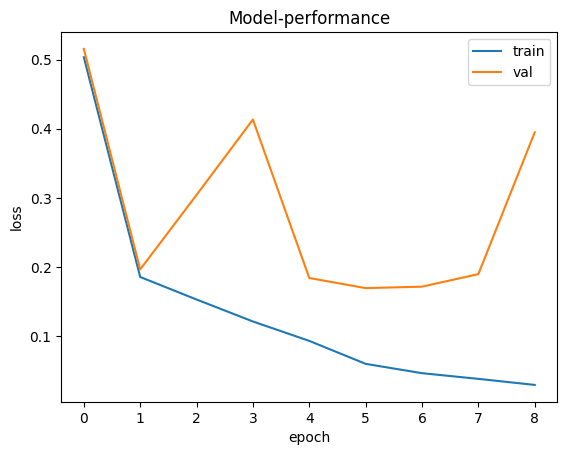

In [ ]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model-performance")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

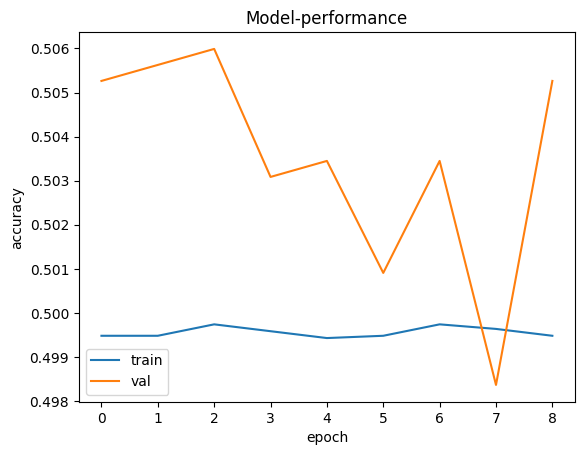

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model-performance")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"])
plt.show

Evaluation

In [ ]:
#for element in test_dataset.take(1):
   # print(element)

test_dataset = test_dataset.batch(1)


In [ ]:
#test_dataset = test_dataset.batch(1)
model.evaluate(test_dataset)

5513/5513 [==============================] - 41s 7ms/step - loss: 3.2071 - tp: 2761.0000 - fp: 2752.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5008 - precision: 0.5008 - recall: 1.0000 - auc: 0.5000


[3.2071268558502197,
 2761.0,
 2752.0,
 0.0,
 0.0,
 0.5008162260055542,
 0.5008162260055542,
 1.0,
 0.5]

Matrix


In [ ]:
labels = []
inp = []
for x, y in test_dataset:
  labels.append(y.as_numpy_iterator())
  inp.append(x.as_numpy_iterator())

print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)
labels = np.array([ i[0] for i  in labels ])


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'as_numpy_iterator'

In [ ]:
predicted = model.predict(np.array(inp))[:,0,...]
predicted[:,0]

In [ ]:
threshold = 0.5
con_mat = confusion_matrix(labels , predicted > threshold)
print(con_mat)
plt.figure(figsize=(8, 8))
plt.title("Confusion Matrix")
sns.heatmap(con_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC plots

In [ ]:
fp , tp , threshold = sklearn.metrics.roc_curve(labels , predicted)
plt.plot(fp , tp)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
skip = 25

for i in range(0, len(fp), skip):
    plt.annotate(f"{threshold[i]:.2f}", (fp[i], tp[i]))

plt.show()

In [ ]:
def unfected_or_not(x):
  if x < 0.5:
    return str("uninfected")
  else:
    return str("infected")

1/1 [==============================] - 0s 28ms/step


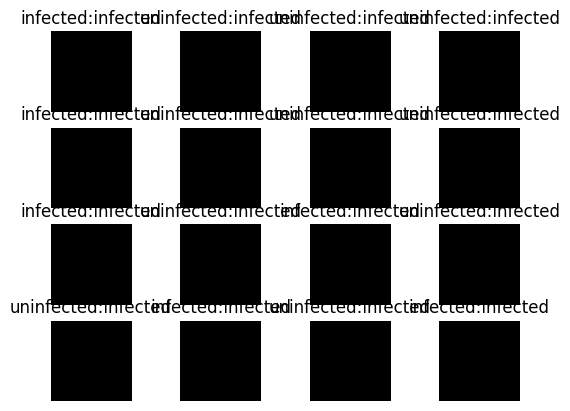

In [ ]:
for i , (image,label) in enumerate(test_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image[0])
  plt.title(str(unfected_or_not(label.numpy()[0])) + ":" + str(unfected_or_not(model.predict(image)[0][0])))
  plt.axis("off")